# Assumptions for the modeling guided by the EDA + intuitions
More trivial:
- temperature is inversed correlated with demand
- wind and solar intensity will bring down the GAS demand
- both the above effects are non linear
- should include day of the week and holidays in dataset

Less trivial: 
- wind and solar energy production increased over the years

Moreover, from the EDA I observe that the dataset is much lower dimensional than the number of features (10 features explain a lot of variance vs. 66 of the original dataset), so should probabily do a PCA step before other trainings. Also, PC1 is already a great indicator for demand.


In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.pipeline import Pipeline
import holidays as pyholidays


from utils import train_and_evaluate_model
from utils import plot_pred_vs_true, plot_errors
from utils import print_train_test_sizes

%matplotlib inline

# Display settings
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)
sns.set_theme(style="whitegrid", context="notebook")

DATA_DIR = Path(".")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
print(train.shape, test.shape)

(3287, 68) (730, 67)


In [11]:
# First test things without holidays and added features
features = train.columns.difference(["id", "date", "demand"]).to_list()
print("Number of numeric/categorical candidate features:", len(features))
X = train[features]
y = train["demand"]
dates = train["date"]
print(f"X: {X.shape}, y: {y.shape}, dates: {dates.shape}")

Number of numeric/categorical candidate features: 65
X: (3287, 65), y: (3287,), dates: (3287,)


In [12]:
# Ensure X is an independent copy to avoid SettingWithCopyWarning
X = X.copy()

# Standardize data before training
scaler = StandardScaler()
X.loc[:, features] = scaler.fit_transform(X[features])

# Add holidays + weekends as a feature (ensure years include the last year)
date_series = pd.to_datetime(train["date"])
years = range(date_series.dt.year.min(), date_series.dt.year.max() + 1)
uk_holidays = pyholidays.UnitedKingdom(years=years)

is_holiday = date_series.dt.date.isin(set(uk_holidays)).astype(int)
day_of_week = date_series.dt.dayofweek
is_weekend = day_of_week.isin([5, 6]).astype(int)

X.loc[train.index, "is_holiday"] = np.maximum(is_holiday, is_weekend).astype(int)

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Linear Regression (log y)": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Spline Linear Regression": Pipeline(
        [
            (
                "spline",
                SplineTransformer(
                    n_knots=3, degree=2, extrapolation="linear", include_bias=False
                ),
            ),
            ("lin", LinearRegression()),
        ]
    ),
    "Spline + Ridge": Pipeline(
        [
            (
                "spline",
                SplineTransformer(
                    n_knots=3, degree=2, extrapolation="linear", include_bias=False
                ),
            ),
            ("ridge", Ridge(alpha=1.0)),
        ]
    ),
}
n_split = 5
training_years = 10

results = {}
for name, est in models.items():
    print(f"=== Training and evaluating {name} ===")
    if "log y" in name:
        # Use log1p/expm1 to avoid -inf for zeros
        results[name] = train_and_evaluate_model(
            model=est,
            X=X,
            y=y,
            date=dates,
            n_splits=n_split,
            training_years=training_years,
            pca_warmup=False,
            target_transform=np.log1p,
        )
    elif "Spline" in name:
        # Avoid applying PCA before spline expansion
        results[name] = train_and_evaluate_model(
            model=est,
            X=X,
            y=y,
            date=dates,
            n_splits=n_split,
            training_years=training_years,
            pca_warmup=False,
            target_transform=None,
        )
    else:
        results[name] = train_and_evaluate_model(
            model=est,
            X=X,
            y=y,
            date=dates,
            n_splits=n_split,
            training_years=training_years,
            pca_warmup=True,
            target_transform=None,
        )

print_train_test_sizes(results)

=== Training and evaluating Linear Regression ===
=== Training and evaluating Linear Regression (log y) ===
=== Training and evaluating Ridge Regression ===
=== Training and evaluating Spline Linear Regression ===
=== Training and evaluating Spline + Ridge ===
=== Linear Regression ===
Fold 1: Train points = 1462, Test points = 365, Ratio = 24.97%
	Training dates: 2009-01-01 to 2013-01-01, Testing dates: 2013-01-02 to 2014-01-01
Fold 2: Train points = 1827, Test points = 365, Ratio = 19.98%
	Training dates: 2009-01-01 to 2014-01-01, Testing dates: 2014-01-02 to 2015-01-01
Fold 3: Train points = 2192, Test points = 365, Ratio = 16.65%
	Training dates: 2009-01-01 to 2015-01-01, Testing dates: 2015-01-02 to 2016-01-01
Fold 4: Train points = 2557, Test points = 365, Ratio = 14.27%
	Training dates: 2009-01-01 to 2016-01-01, Testing dates: 2016-01-02 to 2016-12-31
Fold 5: Train points = 2922, Test points = 365, Ratio = 12.49%
	Training dates: 2009-01-01 to 2016-12-31, Testing dates: 2017-01-

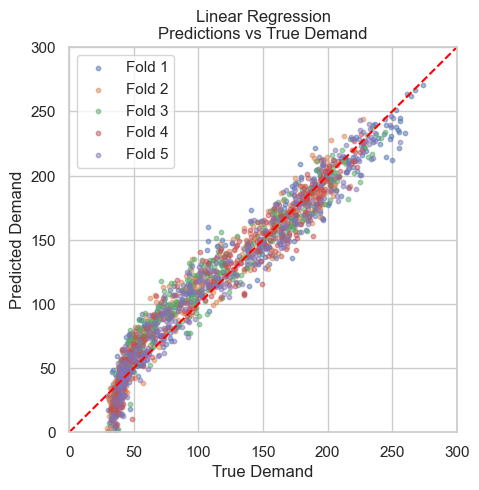

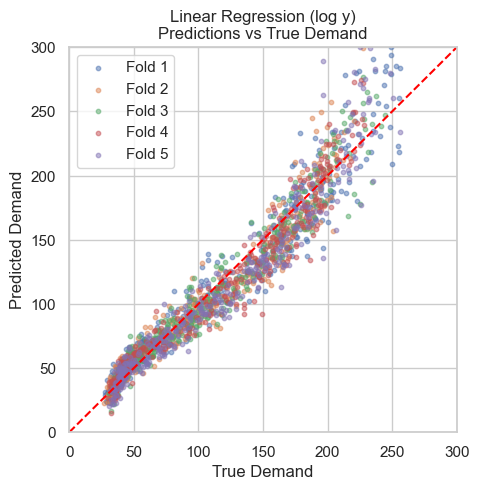

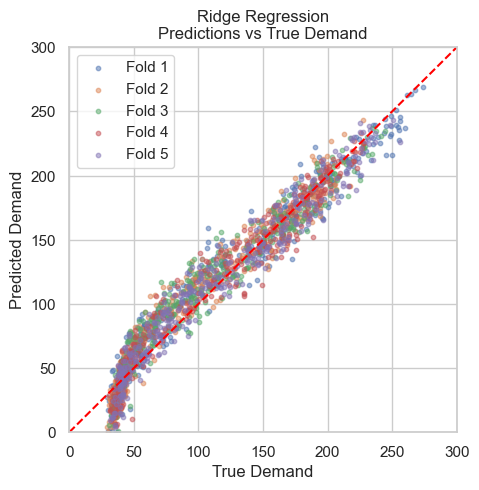

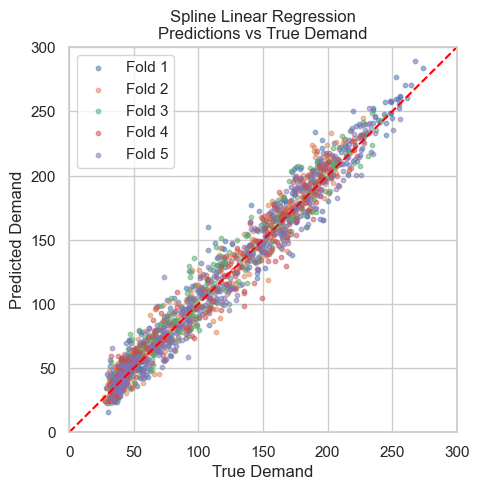

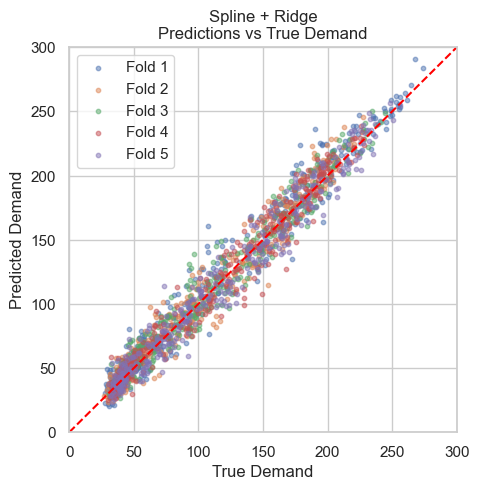

In [14]:
for name, res in results.items():
    plot_pred_vs_true(res["test"], title=f"{name}\nPredictions vs True Demand")

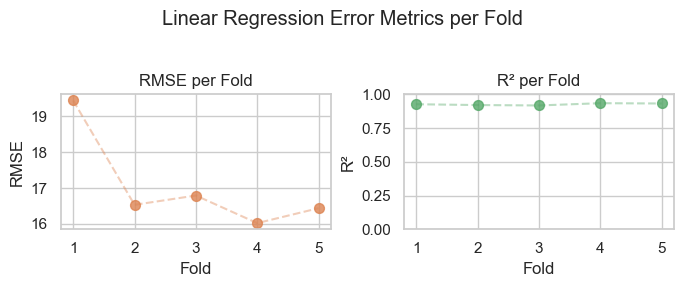

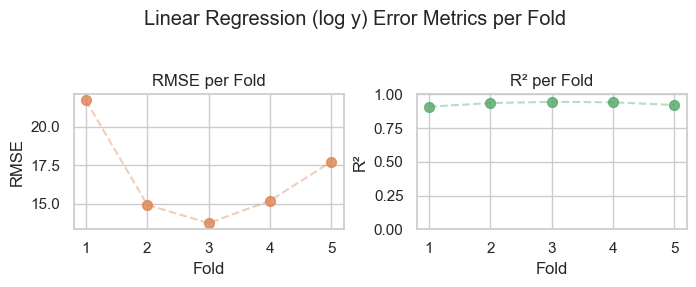

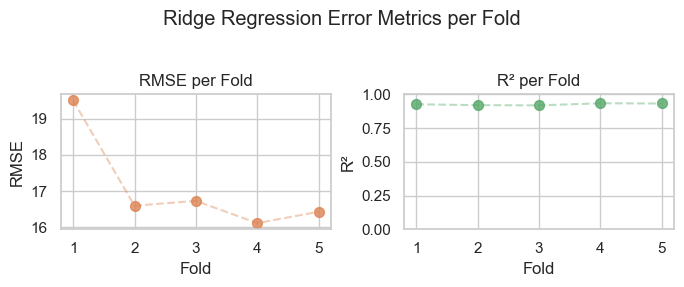

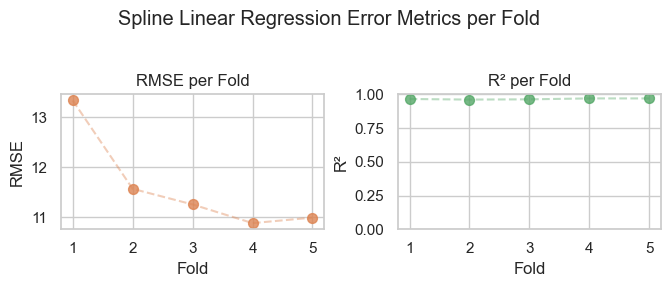

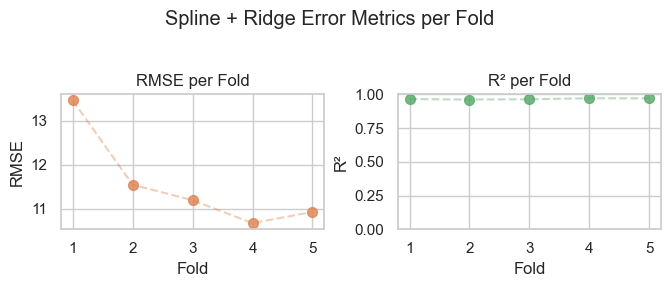

In [15]:
for name, res in results.items():
    plot_errors(res["metrics"], title=f"{name} Error Metrics per Fold")

In [16]:
# Get a table summarizing the results for each model
summary_rows = []
for name, res in results.items():
    metrics = res["metrics"]
    last_fold_metrics = {k: v[-1] for k, v in metrics.items()}
    row = {"Model": name}
    row.update(last_fold_metrics)
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
summary_df

,Model,rmse,r2
0,Linear Regression,16.438997,0.932096
1,Linear Regression (log y),17.740331,0.920920
2,Ridge Regression,16.430254,0.932169
3,Spline Linear Regression,10.992033,0.969640
4,Spline + Ridge,10.926037,0.970004


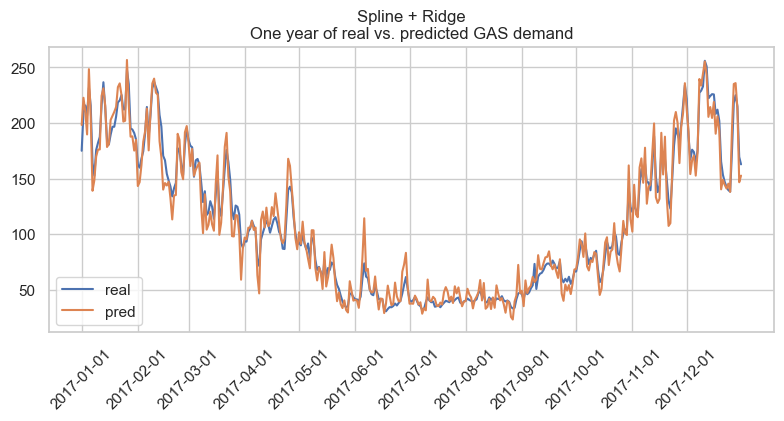

In [17]:
# Choose the best model and plot the last fold prediction vs. real demand over time
best_model_name = summary_df["Model"][summary_df["rmse"]==summary_df["rmse"].min()].values[0]

# For the best model make the plot of the last fold
y_real = results[best_model_name]["test"]["y"][-1]
y_pred = results[best_model_name]["test"]["y_pred"][-1]
dates = results[best_model_name]["test"]["date"][-1]

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(dates, y_real, label = "real")
ax.plot(dates, y_pred, label = "pred")

dates = pd.to_datetime(dates)
unique_months = dates.dt.to_period('M').unique()
xticks = []
for m in unique_months:
	first_date = dates[dates.dt.to_period('M') == m].iloc[0].strftime('%Y-%m-%d')
	xticks.append(first_date)
plt.xticks(xticks, xticks, rotation=45)
plt.tight_layout()

ax.set_title(f"{best_model_name}\nOne year of real vs. predicted GAS demand")
ax.legend()
plt.show()

# Train a model on all the data and find the demand for the test set

In [ ]:
# Prepare the predictions for submission using the best model
final_model = models[best_model_name]

# I want to concatenate train and test and standardize them together then I will train the model only on the test set

,ssrd_ratio_1,ssrd_ratio_10,ssrd_ratio_11,ssrd_ratio_12,ssrd_ratio_13,ssrd_ratio_2,ssrd_ratio_3,ssrd_ratio_4,ssrd_ratio_5,ssrd_ratio_6,ssrd_ratio_7,ssrd_ratio_8,ssrd_ratio_9,temp_1,temp_10,temp_11,temp_12,temp_13,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,temp_9,temp_night_1,temp_night_10,temp_night_11,temp_night_12,temp_night_13,temp_night_2,temp_night_3,temp_night_4,temp_night_5,temp_night_6,temp_night_7,temp_night_8,temp_night_9,wind_1,wind_10,wind_11,wind_12,wind_13,wind_2,wind_3,wind_4,wind_5,wind_6,wind_7,wind_8,wind_9,wind_night_1,wind_night_10,wind_night_11,wind_night_12,wind_night_13,wind_night_2,wind_night_3,wind_night_4,wind_night_5,wind_night_6,wind_night_7,wind_night_8,wind_night_9,is_holiday
0,-0.091342,0.195186,1.440073,1.343471,1.213308,1.346605,0.313774,0.953496,-0.091342,0.317043,-0.417430,-1.697314,-1.359431,-0.949297,-0.834945,-0.931195,-0.898800,-0.884981,-0.919243,-0.956836,-0.938819,-0.949297,-0.832612,-1.019981,-0.919248,-0.893341,-0.734301,-0.694371,-0.785795,-0.782485,-0.790054,-0.746139,-0.786253,-0.824804,-0.734301,-0.630307,-0.840276,-0.764492,-0.737638,1.108561,1.026709,1.290292,1.122651,1.108864,1.100423,0.447431,0.294785,1.108561,0.917640,-0.086347,0.954257,0.885228,2.022256,0.310743,1.305055,0.904260,0.731128,1.543830,0.993676,0.915598,2.022256,1.236755,0.120806,1.514426,1.087611,1.0
1,-1.778326,-1.637684,-1.739002,-1.326428,-1.477703,-1.932871,-1.977802,-1.986142,-1.778326,-1.712381,-1.228774,-1.930131,-1.863446,-0.650656,-0.308972,-0.731997,-0.643349,-0.492960,-0.736547,-0.864845,-0.914818,-0.650656,-0.753124,-1.117026,-0.477961,-0.434825,-0.176999,-0.101413,-0.372917,-0.406431,-0.283075,-0.289846,-0.389274,-0.535713,-0.176999,-0.397571,-1.071412,-0.079169,-0.088323,1.760119,2.105517,1.486102,1.666094,1.971939,1.679173,1.442518,1.159879,1.760119,1.704220,0.012313,1.886784,1.907150,3.342036,3.003914,2.674427,2.613582,2.789753,3.047515,3.275697,2.748534,3.342036,3.379058,0.817845,3.408680,3.210655,0.0
2,0.690402,1.100155,0.167144,0.597866,1.396872,0.156100,0.580092,0.005969,0.690402,-0.359977,-0.298724,1.718958,1.720511,-0.619129,-0.500398,-0.509006,-0.492963,-0.574268,-0.515961,-0.492495,-0.626659,-0.619129,-0.524728,-0.920569,-0.569977,-0.562345,-0.522894,-0.295199,-0.296074,-0.308648,-0.428217,-0.323574,-0.249389,-0.385061,-0.522894,-0.276514,-0.862952,-0.399320,-0.364976,2.816389,2.039079,2.633428,2.292256,1.933612,2.836793,2.703865,1.672419,2.816389,2.876126,-0.128356,2.208913,2.213107,2.090941,0.925204,1.969706,1.608963,1.147955,2.277715,2.361154,1.381052,2.090941,2.402802,-0.682549,1.519802,1.313497,0.0
3,-1.154124,-0.247915,-0.883514,-0.260969,0.037356,-1.318107,-1.998467,-2.165424,-1.154124,-1.586440,-1.380910,-0.888771,-0.527316,-0.690929,-0.449376,-0.891609,-0.861435,-0.657382,-0.839877,-0.888108,-1.013016,-0.690929,-0.866866,-1.120689,-0.471945,-0.477827,-0.706928,-0.367551,-1.058835,-0.988105,-0.724944,-0.936865,-0.736013,-0.877339,-0.706928,-0.682788,-1.004100,-0.441864,-0.438358,1.200152,1.551721,0.723413,0.855079,1.287648,0.986566,0.315871,-0.483546,1.200152,0.526683,-1.203873,1.383434,1.529770,0.013531,0.894640,-0.690283,-0.641531,-0.387714,-0.108195,0.030373,-0.105148,0.013531,0.182937,-1.276150,0.443286,0.362719,0.0
4,1.291609,1.265288,-1.243195,-0.581325,0.120714,-0.836112,-0.516580,-0.428370,1.291609,-0.060886,-0.675737,0.831513,1.297603,-1.145517,-1.399191,-1.489172,-1.568091,-1.468747,-1.364344,-1.295980,-1.185806,-1.145517,-1.210870,-1.251189,-1.020086,-1.127366,-1.335286,-1.554868,-1.680800,-1.567662,-1.667275,-1.552104,-1.026943,-0.882096,-1.335286,-1.079444,-1.016931,-1.082716,-1.240121,-0.062789,-0.382900,-1.200286,-1.160399,-0.384605,-1.054018,-1.115657,-0.469091,-0.062789,-1.015705,-0.252033,-0.029011,-0.142399,-1.217195,-0.363803,-1.137530,-0.990273,-0.501057,-1.125067,-0.386158,0.433492,-1.217195,-0.079033,0.434621,-0.886285,-0.540888,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,